# Problem Statement:

Forecasting energy consumption can be useful for optimizing the energy generation process. Furthermore, it can play a major role in comprehensive planning, operation, management, and cascade utilization of energy systems. It can also act as a key technology to promote the energy market. In this project, we will use the historical data of monthly electricity consumption and forecast the demand for the next 3 years.

In [1]:
# import the required libraries

import pandas as pd
import numpy as np
import sklearn

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.api import ExponentialSmoothing

from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import root_mean_squared_error

## Exploratory Data Analysis

In [2]:
# import dataset

data = pd.read_csv('energy consumption.csv')
data.head()

,DATE,ENERGY_INDEX
0,01/1939,3.3842
1,02/1939,3.4100
2,03/1939,3.4875
3,04/1939,3.5133
4,05/1939,3.5133


Since nothing is mentioned about the unit of Enery index, we assume it to be, ideally be, kWh/m2/month.

In [3]:
data.tail()

,DATE,ENERGY_INDEX
964,05/2019,91.9046
965,06/2019,98.4397
966,07/2019,112.9469
967,08/2019,111.6645
968,09/2019,102.2911


In [4]:
data.shape

(969, 2)

In [5]:
# check data type of the columns and also if null values are present

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          969 non-null    object 
 1   ENERGY_INDEX  969 non-null    float64
dtypes: float64(1), object(1)
memory usage: 15.3+ KB


ie., no null values. However, the date col can be seen as object instead of datetime. So this has to be handled.

In [6]:
# converting Date col data type to datetime

data['DATE'] = pd.to_datetime(data['DATE'], format = '%m/%Y')

# recheck the dtype
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATE          969 non-null    datetime64[ns]
 1   ENERGY_INDEX  969 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.3 KB


In [7]:
# add 2 cols - month and year for further analysis

data['Month'] = data.DATE.dt.month
data['Year'] = data.DATE.dt.year

data.head()

,DATE,ENERGY_INDEX,Month,Year
0,1939-01-01,3.3842,1,1939
1,1939-02-01,3.4100,2,1939
2,1939-03-01,3.4875,3,1939
3,1939-04-01,3.5133,4,1939
4,1939-05-01,3.5133,5,1939


### Visualizations for better understanding

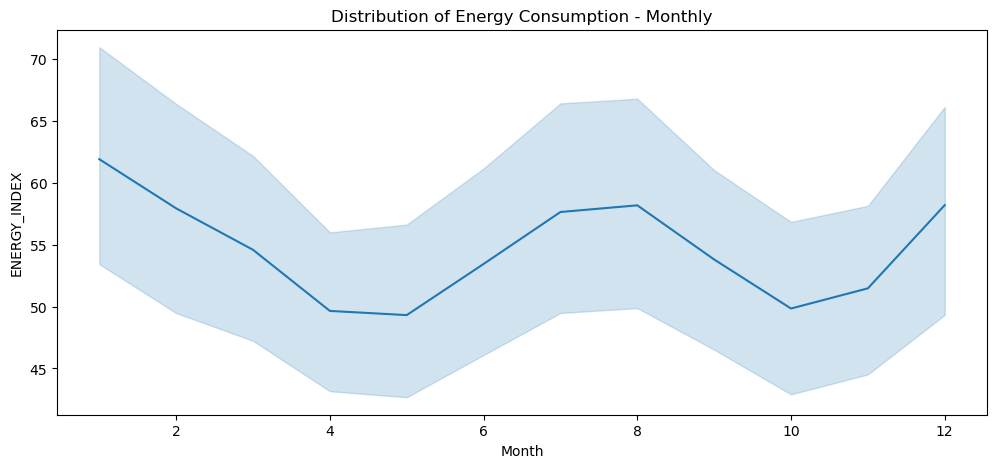

In [8]:
plt.figure(figsize = (12,5))
sns.lineplot(x = data['Month'], y = data['ENERGY_INDEX'])

plt.title('Distribution of Energy Consumption - Monthly');

Note : 
- From January to May, there is a decrease in energy consumption.
- From May to August, there is an increase in energy consumption.
- From August to October, again there is a dip in the energy consumption.
- From October to December, there is an increase in energy consumption.
- Hence, there is presence of trend and seasonality in this monthly data.

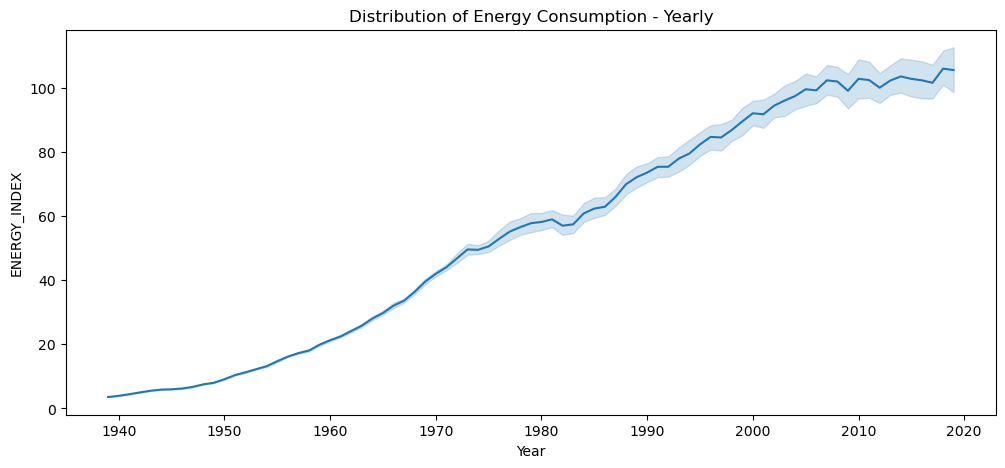

In [9]:
plt.figure(figsize = (12,5))
sns.lineplot(x = data['Year'], y = data['ENERGY_INDEX'])

plt.title('Distribution of Energy Consumption - Yearly');

Note : 
- A clear increasing trend is observed ie., with each passing years the energy consumption has increased.

In [10]:
# set DATE as index so as to use seasonal_decompose()

data.set_index(data['DATE'], inplace = True)

data.head(3)

,DATE,ENERGY_INDEX,Month,Year
DATE,,,,
1939-01-01,1939-01-01,3.3842,1,1939
1939-02-01,1939-02-01,3.4100,2,1939
1939-03-01,1939-03-01,3.4875,3,1939


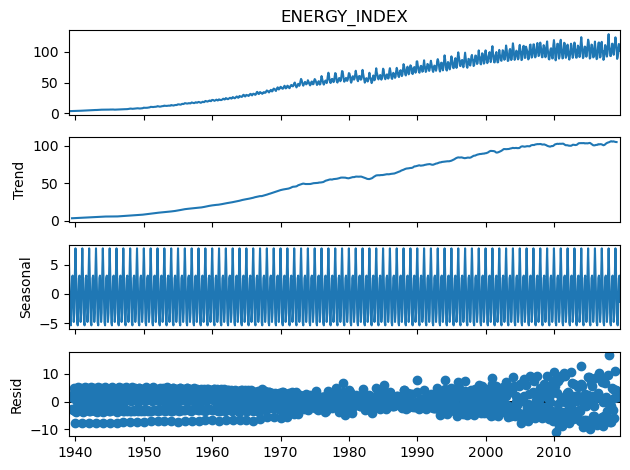

In [11]:
# check out the trend and seasonality

decomposed_series = seasonal_decompose(data['ENERGY_INDEX'])
decomposed_series.plot();

Notice that, as expected -
- There  is an increasing trend.
- There is seasonality.
- There are residuals.

However, its not clear if the seasonality is daily, weekly, monthly etc.

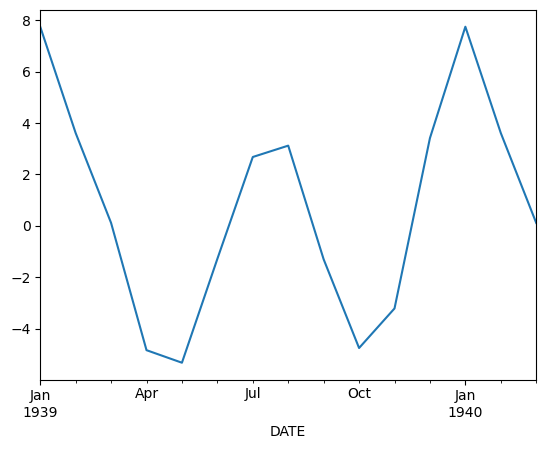

In [12]:
# Visualize a slice of the seasonal component dataset

decomposed_series.seasonal[0:15].plot();

ie., the seasonality is noticed on a yearly basis.

## Model Selection - Holts Winter Exponential Smoothing 

Selecting this model as - 
- The data shows trend and seasonality. Hence these two have to be considered while predicting.
- Easy to understand and interpret.
- No underlying assumptions like stationarity.

### Data segmentation using Time Series Cross Validation

In [13]:
# Converting index to deafult for easier validations

data.reset_index(drop = True, inplace = True)

data.head()

,DATE,ENERGY_INDEX,Month,Year
0,1939-01-01,3.3842,1,1939
1,1939-02-01,3.4100,2,1939
2,1939-03-01,3.4875,3,1939
3,1939-04-01,3.5133,4,1939
4,1939-05-01,3.5133,5,1939


In [14]:
data_cv = TimeSeriesSplit(n_splits=5)

#### Model fitting and Making predictions on the available data

In [15]:
# look into the 5 splits, fit the model for train data and make the predictions for test data

for i, (train_index, test_index) in enumerate(data_cv.split(data)) :
        print('-------------')
        print(f'Fold {i} : ')

        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        #train_data.set_index('DATE', inplace=True)

        # Initialise and Fit the model
        model = ExponentialSmoothing(train_data['ENERGY_INDEX'], seasonal_periods=12, trend='add', seasonal='add')
        fitted_model = model.fit()

        # Make predictions
        predict = fitted_model.forecast(steps = len(test_data))

        print('--------------------')
        print('Train : ', train_index[0], ' to ', train_index[-1])
        print('Test : ', test_index[0], ' to ', test_index[-1])
        print('Predictions : ', predict) 

-------------
Fold 0 : 
--------------------
Train :  0  to  163
Test :  164  to  324
Predictions :  164    11.422563
165    11.452434
166    11.561577
167    11.736125
168    11.934463
         ...    
320    22.011864
321    22.041735
322    22.150878
323    22.325426
324    22.523765
Length: 161, dtype: float64
-------------
Fold 1 : 
--------------------
Train :  0  to  324
Test :  325  to  485
Predictions :  325    31.242418
326    31.200073
327    30.499148
328    30.172110
329    31.186264
         ...    
481    53.207970
482    53.165625
483    52.464700
484    52.137662
485    53.151816
Length: 161, dtype: float64
-------------
Fold 2 : 
--------------------
Train :  0  to  485
Test :  486  to  646
Predictions :  486    57.876747
487    59.647100
488    57.112292
489    54.517850
490    56.668970
         ...    
642    81.145449
643    82.915802
644    80.380994
645    77.786552
646    79.937672
Length: 161, dtype: float64
-------------
Fold 3 : 
--------------------
Train :

## Validating the Model

In [16]:
# checking how well the model performs
rmse = root_mean_squared_error(test_data['ENERGY_INDEX'], predict)
print(' RMSE : ' , rmse)

 RMSE :  7.720826191474745


We note that the RMSE value is pretty low, suggesting that the model is predicting quite well. Hence, we will use this model to predict for the next 3 years.

## Make Forecasts for the next 3 years

In [17]:
# check latest date in the given dataset
data.DATE.max()

Timestamp('2019-09-01 00:00:00')

In [18]:
# create a series with Date starting from 10/2019 to 10/2021 (ie., next 3 years)

Interested_dates = pd.date_range(start = '2019-10-01 00:00:00', end = '2021-10-01 00:00:00', freq = 'MS')

# convert the above to dataframe for required forecasting
Interested_data = pd.DataFrame(data = {'DATE' : Interested_dates})

Interested_data

,DATE
0,2019-10-01
1,2019-11-01
2,2019-12-01
3,2020-01-01
4,2020-02-01
5,2020-03-01
6,2020-04-01
7,2020-05-01
8,2020-06-01
9,2020-07-01


In [19]:
# Redefining the train and test data
train_data = data.iloc[0:969]
test_data = Interested_data

# Initialising and fitting model
model = ExponentialSmoothing(train_data['ENERGY_INDEX'], seasonal_periods=12, trend = 'add', seasonal = 'add')
fitted_model = model.fit()

# Making predictions for the next 3 years (Monthly)
req_forecast = fitted_model.forecast(steps = len(Interested_data))

# Converting predictions to list for easy processing
req_forecast = list(req_forecast)

# Add these forecasts to the required dataframe
Interested_data['Forecasts'] = req_forecast

In [20]:
# Final required DataFrame with the required predictions

# Format Date col as in the real dataset
Interested_data['DATE'] = Interested_data['DATE'].dt.strftime('%m/%Y')

Interested_data

,DATE,Forecasts
0,10/2019,93.997558
1,11/2019,98.908185
2,12/2019,112.396914
3,01/2020,122.037342
4,02/2020,108.132100
5,03/2020,102.924787
6,04/2020,89.249577
7,05/2020,92.098689
8,06/2020,102.110527
9,07/2020,114.614609


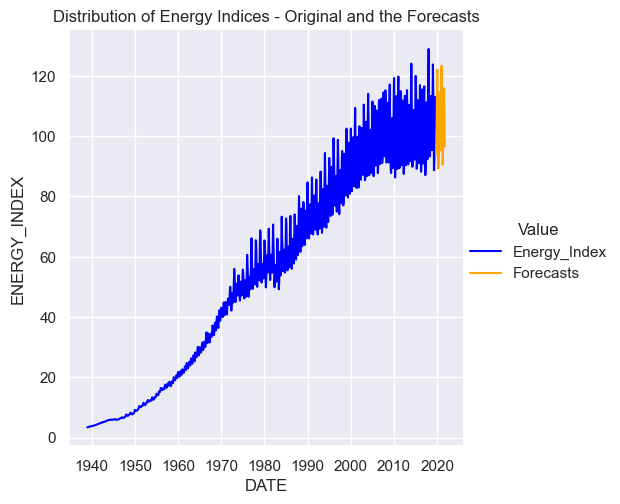

In [21]:
### Merging dataframes for easy comparison of the forecasts

# Creating a copy of Interested_data
Interested_data2 = Interested_data.copy()
Interested_data2['DATE'] = pd.to_datetime(Interested_data2['DATE'], format = '%m/%Y')

# Merge original and newly created dataframes for better visualization
Interested_data2.rename(columns= {'Forecasts' : 'ENERGY_INDEX'}, inplace = True)

data['Value'] = 'Energy_Index'
Interested_data2['Value'] = 'Forecasts'

Final_df = pd.concat([data, Interested_data2], ignore_index = True)

# Plot original data and the forecasts
sns.set(rc={'figure.figsize':(10,5)})
sns.relplot(x=Final_df['DATE'], y=Final_df['ENERGY_INDEX'], kind="line", hue="Value", palette=['blue', 'orange'], data=Final_df)
plt.title('Distribution of Energy Indices - Original and the Forecasts');

**Hence, we have forecasted the Energy Indices for the next 3 years as required.**

-----------------------------------------------x--------------------------------------x-------------------------------------------------